##Import Libraries

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

%pylab inline

Populating the interactive namespace from numpy and matplotlib


##Data Generation

We use a two-class synthetic dataset from two different Gaussian density functions.
\begin{eqnarray}
p(\mathbf{x}|\mu_c, \Sigma_c) = \frac{1}{\sqrt{2\pi}|\Sigma_c|^\frac{1}{2}} \exp\left(-\frac{1}{2}(\mathbf{x} - \mu_c)^\top\Sigma_c^{-1}(\mathbf{x} - \mu_c)\right)   \quad \text{for class} \quad c = \{1,2\}
\end{eqnarray}

The first class uses $\mu_1 = \left(\begin{array}{c}
4 \\
0
\end{array}\right)$, $\Sigma_1 = \left(\begin{array}{cc}
3 & 2 \\
2 & 3
\end{array}\right)$, and the second class uses $\mu_2 = \left(\begin{array}{c}
0 \\
4
\end{array}\right)$, $\Sigma_2 = \left(\begin{array}{cc}
3 & 2 \\
2 & 3
\end{array}\right)$.

In [2]:
n_data_per_class = 100
num_class = 2
dim_data = 2
n_data = n_data_per_class * num_class
n_train = n_data_per_class

data1 = np.random.multivariate_normal([4,0], [[3,2],[2,3]], n_data_per_class).astype(np.float32)
data2 = np.random.multivariate_normal([0,4], [[3,2],[2,3]], n_data_per_class).astype(np.float32)
data_x = np.vstack([data1,data2])
data_y = np.hstack([np.ones((n_data_per_class,)), np.zeros((n_data_per_class,))])

blues are class 0 and reds are class 1


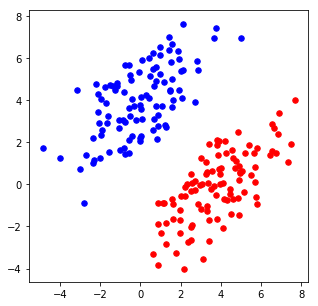

In [3]:
print 'blues are class 0 and reds are class 1'
plt.rcParams['figure.figsize']=(5,5)
plt.scatter(data1[:,0],data1[:,1],30,'r')
plt.scatter(data2[:,0],data2[:,1],30,'b')
[x1min,x1max,x2min,x2max] = plt.axis()
x1val = np.arange(x1min,x1max,0.1)
plt.axis([x1min,x1max,x2min,x2max])
plt.show()

##Logistic Regression

\begin{align}
y_n &= \sigma(\mathbf{w}^{\top} x + b) \\
p(y | \mathbf{w}, b) &= \prod_{n=1}^{N} y_n^{y_{true}} (1-y_n)^{1-y_{true}} \\
loss &= -\sum_{n=1}^{N} y_{true}ln y_n + (1-y_{true})ln(1-y_n)
\end{align}

In [4]:
x = tf.placeholder(tf.float32, [None, dim_data])
W = tf.Variable(np.reshape(np.array([3.0, 0.5], dtype=float32), (2,1)))
b = tf.Variable(0.0)
y_true = tf.placeholder(tf.float32, [None])

a = tf.sigmoid(tf.matmul(x, W) + b)
#p_y = tf.sigmoid(tf.multiply(a ,tf.reshape(y_true, [-1,1]) ))

#loss = tf.reduce_mean(tf.multiply(y_true, a) + tf.multiply(1-y_true, 1-a))
loss = -tf.reduce_mean(tf.multiply(tf.reshape(y_true, [-1,1]), a) + tf.multiply(tf.reshape(np.array([1], dtype=float32), [-1,1])-tf.reshape(y_true, [-1,1]), tf.reshape(np.array([1], dtype=float32), [-1,1])-a))
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(loss)



In [5]:
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())


##FDA

In [6]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# LDA
sklearn_lda = LDA(n_components=2)


##Compare the models

In [7]:
def run_models(num_train_data, num_training_steps=30):
    
    sess.run(tf.global_variables_initializer())
    
    wval = sess.run(W) # 2 by 1   
    bval = sess.run(b) # 1
    #print wval, bval
    
    train_x = np.vstack([data1[:num_train_data],data2[:num_train_data]])
    train_y = np.hstack([np.ones((num_train_data,)), np.zeros((num_train_data,))])

    test_x = np.vstack([data1[num_train_data:],data2[num_train_data:]])
    num_test = n_data_per_class-num_train_data
    test_y = np.hstack([np.ones((num_test,)), np.zeros((num_test,))])
    
    w_history = []
    b_history = []
    acc_history = []
    loss_history = []
    for i in range(num_training_steps):
        sess.run(train_step, feed_dict={x: train_x, y_true: train_y})
        w_history.append( sess.run(W) )
        b_history.append( sess.run(b) )
        #loss_history.append( sess.run(loss))
        loss_history.append( sess.run(loss, feed_dict={x: train_x, y_true: train_y}) )
    
    
        a_tst = sess.run(a, feed_dict = {x:test_x, y_true: test_y})
        n_correct_c1 = sum(a_tst[:num_test] >= 0.5)
        n_correct_c2 = sum(a_tst[num_test:] < 0.5)
        acc = (n_correct_c1 + n_correct_c2) / (float(num_test)*2)
    
        acc_history.append(acc)
    
    return w_history, b_history, acc_history, loss_history

   

In [8]:
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

In [9]:
def visualize(w_his, b_his, acc_his, loss_his, iter_step, num_train_data):
    num_test = n_data_per_class-num_train_data

    plt.subplot(221)
    plt.rcParams['figure.figsize']=(25,5)
    plt.scatter(data1[:num_train_data,0],data1[:num_train_data,1],30,'r')
    plt.scatter(data2[:num_train_data,0],data2[:num_train_data,1],30,'b')
    [x1min,x1max,x2min,x2max] = plt.axis()
    x1val = np.arange(x1min,x1max,0.1)
    wval = w_his[iter_step] # 2 by 1   
    bval = b_his[iter_step] # 1
    plt.plot(x1val, -(wval[0]*x1val+bval)/wval[1], 'k')
    plt.axis([x1min,x1max,x2min,x2max])



    plt.subplot(223)
    #plt.rcParams['figure.figsize']=(25,10)
    plt.scatter(data1[num_train_data:,0],data1[num_train_data:,1],30,'r')
    plt.scatter(data2[num_train_data:,0],data2[num_train_data:,1],30,'b')
    [x1min,x1max,x2min,x2max] = plt.axis()
    x1val = np.arange(x1min,x1max,0.1)
    #wval = sess.run(W) # 2 by 1   
    #bval = sess.run(b) # 1
    plt.plot(x1val, -(wval[0]*x1val+bval)/wval[1], 'k')
    plt.axis([x1min,x1max,x2min,x2max])

    print "accuracy of the LR: " + str(acc_his[iter_step])

    
    
    train_x = np.vstack([data1[:num_train_data],data2[:num_train_data]])
    train_y = np.hstack([np.ones((num_train_data,)), np.zeros((num_train_data,))])

    test_x = np.vstack([data1[num_train_data:],data2[num_train_data:]])
    test_y = np.hstack([np.ones((num_test,)), np.zeros((num_test,))])
    

    plt.subplot(222)
    X_lda_sklearn = sklearn_lda.fit_transform(train_x, train_y)
    transformed = sklearn_lda.transform(train_x)
    #plt.rcParams['figure.figsize']=(5,5)
    plt.scatter(transformed[:num_train_data,0], np.ones(num_train_data), 30,'r')
    plt.scatter(transformed[num_train_data:,0], np.zeros(num_train_data), 30,'b')
    [x1min,x1max,x2min,x2max] = plt.axis()
    x1val = np.arange(x1min,x1max,0.1)
    plt.axis([x1min,x1max,x2min,x2max])

    
    plt.subplot(224)
    transformed = sklearn_lda.transform(test_x)
    plt.scatter(transformed[:num_test,0], np.ones(num_test), 30,'r')
    plt.scatter(transformed[num_test:,0], np.zeros(num_test), 30,'b')
    [x1min,x1max,x2min,x2max] = plt.axis()
    x1val = np.arange(x1min,x1max,0.1)
    plt.axis([x1min,x1max,x2min,x2max])

    tst_result = sklearn_lda.predict(test_x)
    n_correct_c1 = sum(tst_result[:num_test] == 1)
    n_correct_c2 = sum(tst_result[num_test:] == 0)

    acc = (n_correct_c1 + n_correct_c2) / (float(num_test)*2)
    print "accuracy of the FDA: " + str(acc)


##Learning curve (according to the epoch)

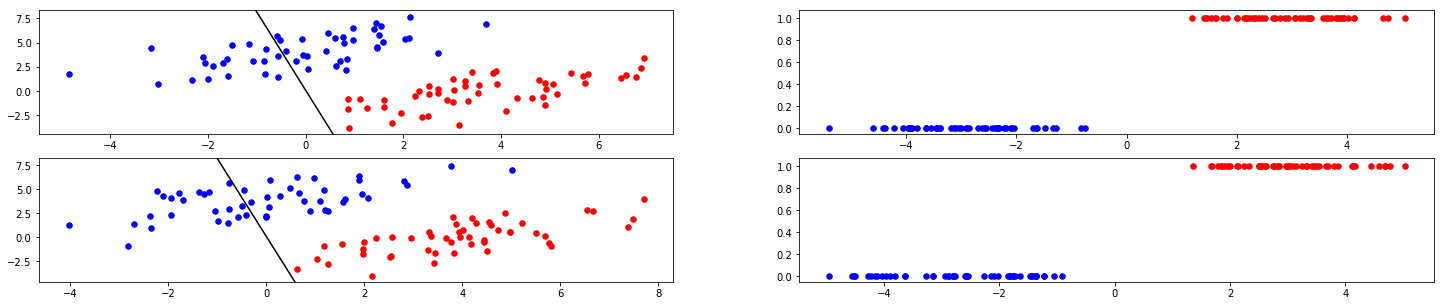

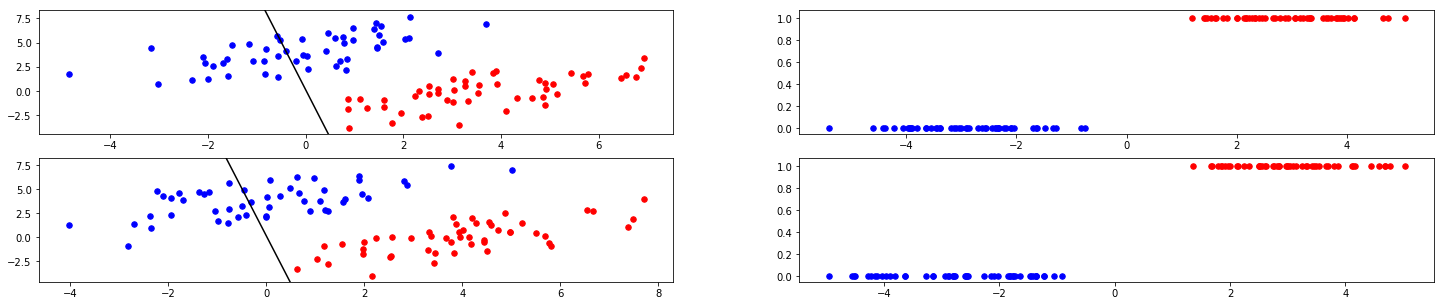

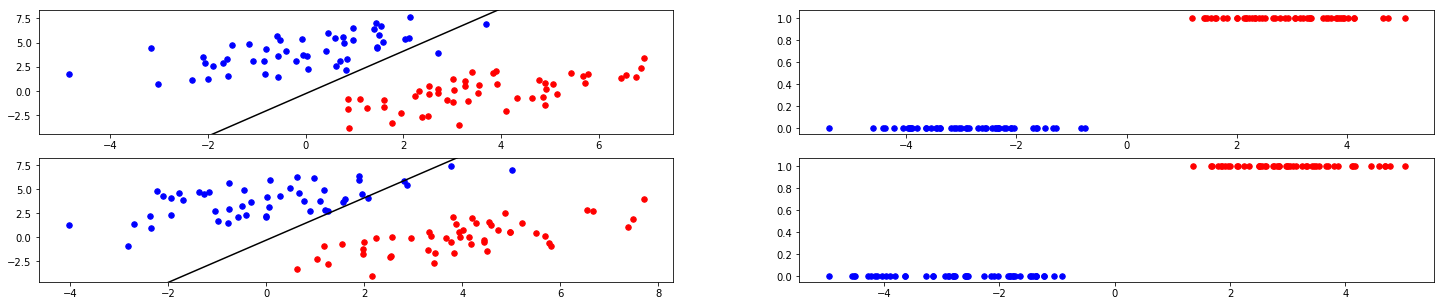

In [11]:
#a_slider = widgets.IntSlider(min=3, max=n_data_per_class, step=1, value=3)
#w_his, b_his = widgets.interactive(run_models, num_train_data = a_slider)
num_train_data = 50
w_his, b_his, acc_his, loss_his = run_models(num_train_data)
b_slider = widgets.IntSlider(min=1, max = 30, step = 1, value = 1)
w=widgets.interactive(visualize, w_his = fixed(w_his), b_his = fixed(b_his), acc_his = fixed(acc_his), loss_his = fixed(loss_his), num_train_data = fixed(num_train_data), iter_step = b_slider)
#w=widgets.interactive(visualize, w_his = w_his, b_his = b_his, num_train_data = num_train_data, iter_step = b_slider)
display(w)

##Compare the Loss of the two functions according to the number of the training data

In [57]:
loss_lr = []
loss_fda = []

for num_train_data in range(5,50):
    _, _, acc_his_lr, _ = run_models(num_train_data, 50)
    loss_lr.append([num_train_data, 1-acc_his_lr[-1]])
    
    train_x = np.vstack([data1[:num_train_data],data2[:num_train_data]])
    train_y = np.hstack([np.ones((num_train_data,)), np.zeros((num_train_data,))])
    
    num_test = n_data_per_class-num_train_data

    test_x = np.vstack([data1[num_train_data:],data2[num_train_data:]])
    test_y = np.hstack([np.ones((num_test,)), np.zeros((num_test,))])
     
    X_lda_sklearn = sklearn_lda.fit_transform(train_x, train_y)
    
    tst_result = sklearn_lda.predict(test_x)
    n_correct_c1 = sum(tst_result[:num_test] == 1)
    n_correct_c2 = sum(tst_result[num_test:] == 0)

    acc_fda =  (n_correct_c1 + n_correct_c2) / (float(num_test)*2) 
    loss_fda.append([num_train_data, 1-acc_fda])
    

In [58]:
loss_lr = np.vstack(loss_lr)
loss_fda = np.vstack(loss_fda)

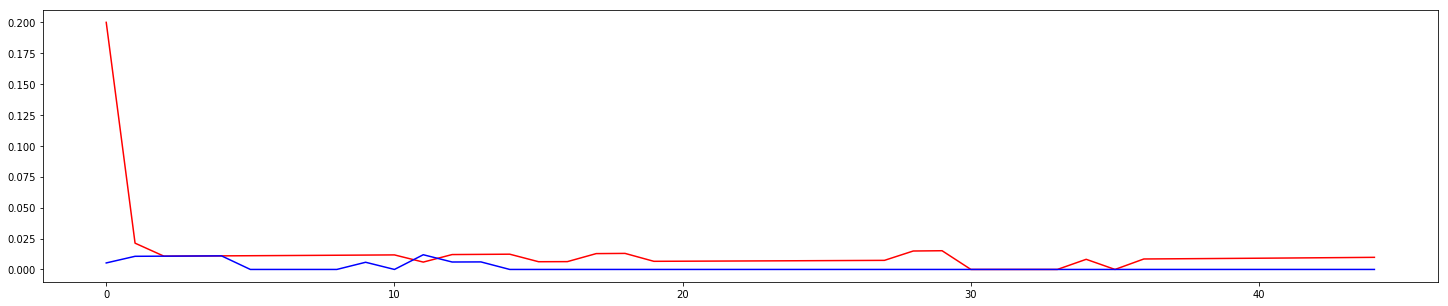

In [64]:
figure

plt.plot(loss_lr[:, 1], 'r')
plt.plot(loss_fda[:, 1], 'b')
#plt.scatter(loss_lr[:, 0], loss_lr[:, 1], 30, 'r')
#plt.scatter(loss_fda[:, 0], loss_fda[:, 1], 30, 'b')
plt.show()